# Data Science Challenge

Problema a resolver:

> Dentro del marketplace existen productos similares o idénticos entre sí (son productos vendidos por distintos sellers, en la api puedes obtener y descargar los títulos e incluso las imágenes!). ¿Cómo buscar dichos ítems para agruparlos y volverlos comparables entre sí? Esto permitiría mejorar la experiencia ante muchas opciones similares.

La solución propuesta compara la información en los títulos y en los atributos de cada producto para encontrar otros productos dentro de la misma subcategoría que se le asemejen. La información contenida en las imágenes de los productos también podría ser útil en este tarea, pero no fue necesaria para obtener este primer prototipo. Además, comparar imágenes incurre en mayores costos de implementación y de computación posteriores. Otro tipo de información que hubiese resultado útil es la de visitas, pero esta no se encuentra disponible en la API pública por lo que pude ver (sí se puede ver cuantas visitas recibió un seller o item, pero no se pueden ver las visitas de cada comprador). No utilizo las descripciones de los artículos ya que su información suele ser redundante a la del título o atributos y suelen tener mucho texto no pertinente y difícil de ponderar (como presentaciones o aclaraciones del seller). La solución propuesta permite filtrar o sopesar los resultados bajo distintos criterios, por ejemplo, si se quiere o no que los productos mostrados sean del mismo seller o marca.

In [64]:
# Cargo los módulos a utilizar
import requests

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.feature_extraction.text as sktext
import sklearn.neighbors as skneigh
import sklearn.manifold as skmani
import nltk.corpus as corpus

%matplotlib inline

In [65]:
def attr_parser(item_attrs, cat_attrs):
    """
    Función para parsear y ordenar los atributos de cada item
    de acuerdo a los atributos de su categoría.
    
    Parameters
    ----------
    
    items_attrs : list
        Lista con los atributos de cada item.
        Obtenida de f'https://api.mercadolibre.com/items/{item_id}'.
        
    cat_attrs : list
        Lista con los atributos de la categoría.
        Obtenida de f'https://api.mercadolibre.com/categories/{cat_id}/attributes'.
        
    Returns
    -------
    
    parsed : list
        Lista con los atributos del item ordenados según cat_attrs
        y transformado a valores numéricos (floats).
    """
    
    parsed = []
    for base_attr in cat_attrs:
        attr_id = base_attr['id'] 

        # Look for attribute
        attribute_found = False
        for attr in item_attrs:
            if attr['id'] == attr_id:
                value_type = base_attr['value_type']
                try:
                    if   value_type == 'number':
                        parsed.append(float(attr['value_name']))
                    elif value_type == 'number_unit':
                        # TODO: conversor de unidades
                        parsed.append(attr['value_struct']['number']) 
                    elif value_type == 'string':
                        # TODO: apply tokenizer to attribute
                        parsed.append(float(attr['value_id']))
                    elif value_type == 'boolean':
                        parsed.append(1.0 if attr['value_id']=='242085' else 0.0)
                    elif value_type == 'list':
                        # TODO: implement list parsing
                        parsed.append(0.0)
                except:
                    parsed.append(0.0)
                
                attribute_found = True
                break

        # Attribute not found
        if not attribute_found:
            parsed.append(0.0)
    
    return parsed

Para definir la categoría a analizar tomo algún producto del marketplace. Este producto es tomado como target principal, aunque el análisis hace una comparación de todos los agrupamientos dentro de la categoría también.

In [66]:
# Target
site_id = 'MLA' # Argentina

target_id = f'{site_id}1101556021' # Multiprocesadora
# target_id = f'{site_id}1100783124' # Pila AAA
# target_id = f'{site_id}928959843' # Bar Carrito
# target_id = f'{site_id}801358441' # Stereo Auto

In [67]:
# Obtengo la información del producto objetivo
url  = f'https://api.mercadolibre.com/items/{target_id}'
req  = requests.get(url)
info = req.json()
target = info['title']

print('Item a buscar:', target)

Item a buscar: Multiprocesadora Smartlife Sl-fp0509 1000w Negra Y Acero Inoxidable 220v - 240v


Obtengo la categoría y busco sus atributos. Gracias al esfuerzo puestos en generar y mantener un buen árbol de categorías es fácil restringir el universo de búsquedas.

Cabe destacar que funciones de la API tales como _domain discovery_ realizan una tarea similar a la aquí propuesta y sería interesante comparar approaches.

In [68]:
# Obtengo la categoría del producto y sus atributos
cat_id = info['category_id']
url = f'https://api.mercadolibre.com/categories/{cat_id}/attributes'
req = requests.get(url)
cat_attrs = req.json()
target_attr = attr_parser(info['attributes'], cat_attrs)
target_attr = np.array(target_attr).reshape(1,-1)
target_loc  = info['seller_address']['search_location']['state']['id']

In [69]:
# Busco los items dentro de la subcategoría
limit = 50
items = []

url = f'https://api.mercadolibre.com/sites/{site_id}/search?category={cat_id}'
req = requests.get(url)

total = req.json()['paging']['total']
if total>200: total = 200 # Este valor suele ser suficiente para encontrar matches apropiados

items = items + req.json()['results']
for offset in range(limit, total, limit):
    url = f'https://api.mercadolibre.com/sites/{site_id}/search?category={cat_id}&offset={offset}'
    req = requests.get(url)
    info  = req.json()
    
    items = items + info['results']

A continuación extraigo más información de los items seleccionados (no todos los atributos son descargados en el proceso anterior) y filtro por ubicación geográfica.

In [70]:
titles      = []
item_ids    = []
attributes  = []
for unit in items:
    url  = f'https://api.mercadolibre.com/items/{unit["id"]}'
    req  = requests.get(url)
    info = req.json()
    try:
        # Restricción geográfica
        if info['seller_address']['search_location']['state']['id'] == target_loc:
            item_ids.append(info['id'])
            titles.append(info['title'])
            attributes.append(attr_parser(info['attributes'], cat_attrs))
    except KeyError:
        pass
    
titles     = np.array(titles)
item_ids   = np.array(item_ids)
attributes = np.array(attributes)

Algunos atributos están ordenados y hasta pueden ser contínuos, como el precio, pero otros, como la marca, no. Esto puede tener consecuencias interesantes a la hora de comparar atributos.

In [71]:
# Normalizo atributos
print(np.shape(attributes))
attrs_max = attributes.max(axis=0)
attrs_max[attrs_max==0.0] = 1

(146, 51)


In [72]:
target_attr = target_attr/attrs_max
attributes  = attributes/attrs_max

# Agrupamientos

Ya obtenida la información realizo agrupamientos mediante el método de Nearest Neighbors.

## Agrupamiento por títulos

In [73]:
# Tokenizo y normalizo los títulos
count_vect = sktext.CountVectorizer(stop_words=corpus.stopwords.words('spanish'))
tfidf_tran = sktext.TfidfTransformer()

X = count_vect.fit_transform(titles)
X = tfidf_tran.fit_transform(X)

In [74]:
# Armo el mapa
nnalg_text = skneigh.NearestNeighbors()
nnalg_text.fit(X)

NearestNeighbors()

In [75]:
# Realizo la predicción
predict = count_vect.transform([target])
predict = tfidf_tran.transform(predict)
dist_text, res_text = nnalg_text.kneighbors(predict, return_distance=True)

print(np.array(titles)[res_text[0]])
print(dist_text)

['Multiprocesadora Smartlife Sl-fp0509 1000w Negra Y Acero Inoxidable 220v - 240v'
 'Multiprocesadora Smartlife Con Licuadora 1000w Fp509 Acero'
 'Multiprocesadora Liliana Fullpros Am790 1000w Negra 220v - 240v'
 'Multiprocesadora Liliana Fullprocessor Am780 750w Negra 220v - 240v'
 'Multiprocesadora Liliana Premiumpros Am468 800w Negra 220v - 240v']
[[0.         1.02408658 1.13592174 1.2236548  1.22666604]]


Comparar solo los títulos suele darle más importancia a productos iguales o de la misma marca.

In [76]:
total_text_dist, total_text_idxs = nnalg_text.kneighbors(X)

## Agrupamiento por atributos

In [77]:
# Armo el mapa
nnalg_attr = skneigh.NearestNeighbors()
nnalg_attr.fit(attributes)

NearestNeighbors()

In [78]:
# Realizo la predicción
dist_attr, res_attr = nnalg_attr.kneighbors(target_attr, return_distance=True)

print(np.array(titles)[res_attr[0]])
print(dist_attr)

['Multiprocesadora Smartlife Sl-fp0509 1000w Negra Y Acero Inoxidable 220v - 240v'
 'Multiprocesadora Smartlife Con Licuadora 1000w Fp509 Acero'
 'Multiprocesadora Electrolux Fpl21 600w Negra 220v'
 'Multiprocesadora Electrolux 600w 1,2lt 3 Vel Fpl21 Licuadora'
 'Multiprocesadora Electrolux 600w 1,2 Lts 3 Velocidades Fpl20']
[[0.         0.0192403  1.70492898 1.70712729 1.70715781]]


Comparar atributos provee una mayor amplitud de respuesta.

In [79]:
total_attr_dist, total_attr_idxs = nnalg_attr.kneighbors(attributes)

## Comparación

Analizo las predicciones de cada agrupamiento sobre todos los productos seleccionados de la categoría. En la práctica podría hacer un agrupamiento que combine tanto títulos como atributos. Aquí me interesó mantenerlos separados para analizar la robustez del método.

Text(0, 0.5, 'Predicción')

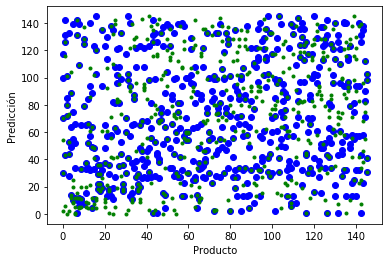

In [80]:
plt.plot(total_attr_idxs[:,1:], 'bo') # Resultados agrupados por títulos
plt.plot(total_text_idxs[:,1:], 'g.') # Resultados agrupados por atributos
plt.xlabel('Producto')
plt.ylabel('Predicción')

In [81]:
# Calculo la correlación entre ambas predicciones
np.sum(np.sort(total_attr_idxs[:,1:])==np.sort(total_text_idxs[:,1:]))/(4*len(titles))

0.18664383561643835

Existe una correlación entre ambas predicciones, aunque no son exactamente iguales, como es de esperar.

In [86]:
# Veo otro ejemplo
ii = 3
print(np.array(titles)[total_attr_idxs[ii]],'\n',np.array(titles)[total_text_idxs[ii]])

['Multiprocesadora Philips Viva Collection Hr7630 600w Negra 220v'
 'Multiprocesadora Philips Viva Collection Hr7630/90 600w 2vel'
 'Procesadora Philips Hr7630/90 Licuadora 600w 21 Funciones'
 'Procesadora Philips Hr7632/90 600w Con Licuadora Exprimidor'
 'Multiprocesadora Philips Viva Collection Hr7630/90'] 
 ['Multiprocesadora Philips Viva Collection Hr7630 600w Negra 220v'
 'Multiprocesadora Philips Viva Collection Hr7630/90 600w 2vel'
 'Multiprocesadora Philips Viva Collection Hr7630/90 600w 2vel'
 'Multiprocesadora Philips Viva Collection Hr7630/90'
 'Multiprocesadora Philips Viva Collection Hr7615 600w Blanca 220v']


Unas consideraciones posibles a tener en cuenta son separar por seller, por marca, o por precio, por ejemplo (además de la restricción geográfica ya implementada). Esto depende un poco de la estrategia de venta y que se le quiere mostrar al usuario. Se puede implementar desde el mismo algoritmo de Nearest Neighbors pasandole una métrica que pese más o menos a las distintas variables, o pre- o post-procesando los resultados también.

Otra forma posible de analizar las predicciones es haciendo una visualización del tipo _t-SNE_.

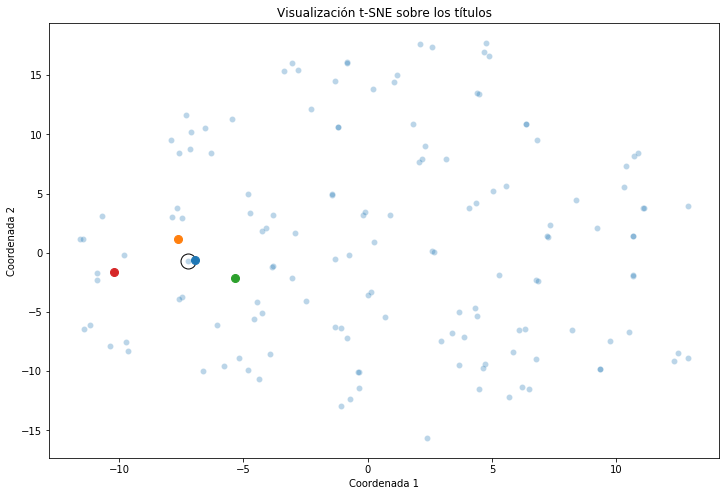

In [83]:
# t-SNE sobre los títulos
tsne = skmani.TSNE(n_components=2)
tsne_results = tsne.fit_transform(X)
 
data = {}
data['tsne-2d-one'] = tsne_results[:,0]
data['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(12,8))

# Visualizo los puntos
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    palette=sns.color_palette("hls", 10),
    data=data,
    legend="full",
    alpha=0.3
)
plt.xlabel('Coordenada 1')
plt.ylabel('Coordenada 2')
plt.title('Visualización t-SNE sobre los títulos')

# Agrego las predicciones
ii = res_text[0][0]
plt.plot(data['tsne-2d-one'][ii], data['tsne-2d-two'][ii], 'ko', markersize=15, markerfacecolor='none')

for ii in res_text[0][1:]:
    plt.plot(data['tsne-2d-one'][ii], data['tsne-2d-two'][ii], 'o', markersize=8)


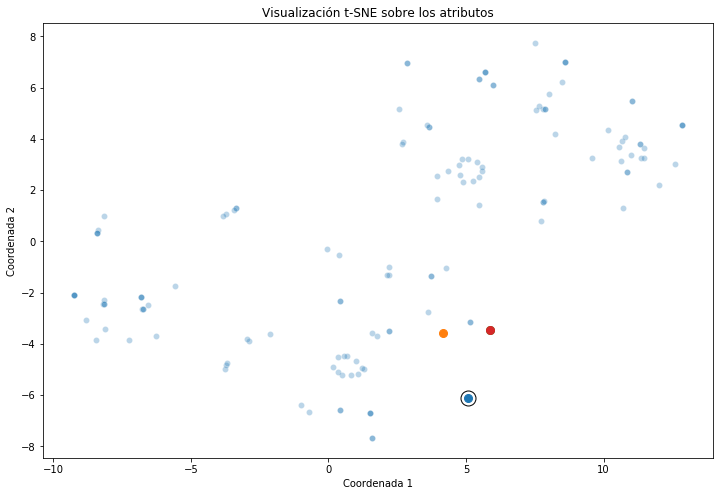

In [85]:
# t-SNE sobre los atributos
tsne = skmani.TSNE(n_components=2)
tsne_results = tsne.fit_transform(attributes)
 
data = {}
data['tsne-2d-one'] = tsne_results[:,0]
data['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(12,8))


sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    palette=sns.color_palette("hls", 10),
    data=data,
    legend="full",
    alpha=0.3
)
plt.xlabel('Coordenada 1')
plt.ylabel('Coordenada 2')
plt.title('Visualización t-SNE sobre los atributos')

# Agrego las predicciones
ii = res_attr[0][0]
plt.plot(data['tsne-2d-one'][ii], data['tsne-2d-two'][ii], 'ko', markersize=15, markerfacecolor='none')

for ii in res_attr[0][1:]:
    plt.plot(data['tsne-2d-one'][ii], data['tsne-2d-two'][ii], 'o', markersize=8)


Podemos observar la existencia de clusters en los datos. Las predicciones obtenidas suelen estar en la vecindad del punto (aunque no sean estrictamente los más cercanos en esta visualización).